In [2]:
# Load ResNet pretrained on ImageNet

import torch
import torchvision
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time

from load_data import get_balanced_dataloader, BagDataset, TRANSFORMS
from eval import get_accuracy_per_class

DATA_DIR = "../../data/biopsies_s1.0_anon_data/"

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: {}".format(device))

Device: cuda


In [2]:
transform = TRANSFORMS["basic_normalize"]

biopsies_dataset = BagDataset(root_dir=DATA_DIR, class_names=["Wildtype", "Overexpression", "Nullmutation", "Doubleclone"], 
    size=64, labels_filename="test", transform=transform, data_limit=None)
print(f"Dataset size: {len(biopsies_dataset)}")

Class distribution:  {'Wildtype': 15, 'Overexpression': 15, 'Nullmutation': 15, 'Doubleclone': 15}
Loaded bags from file
Dataset size: 60


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


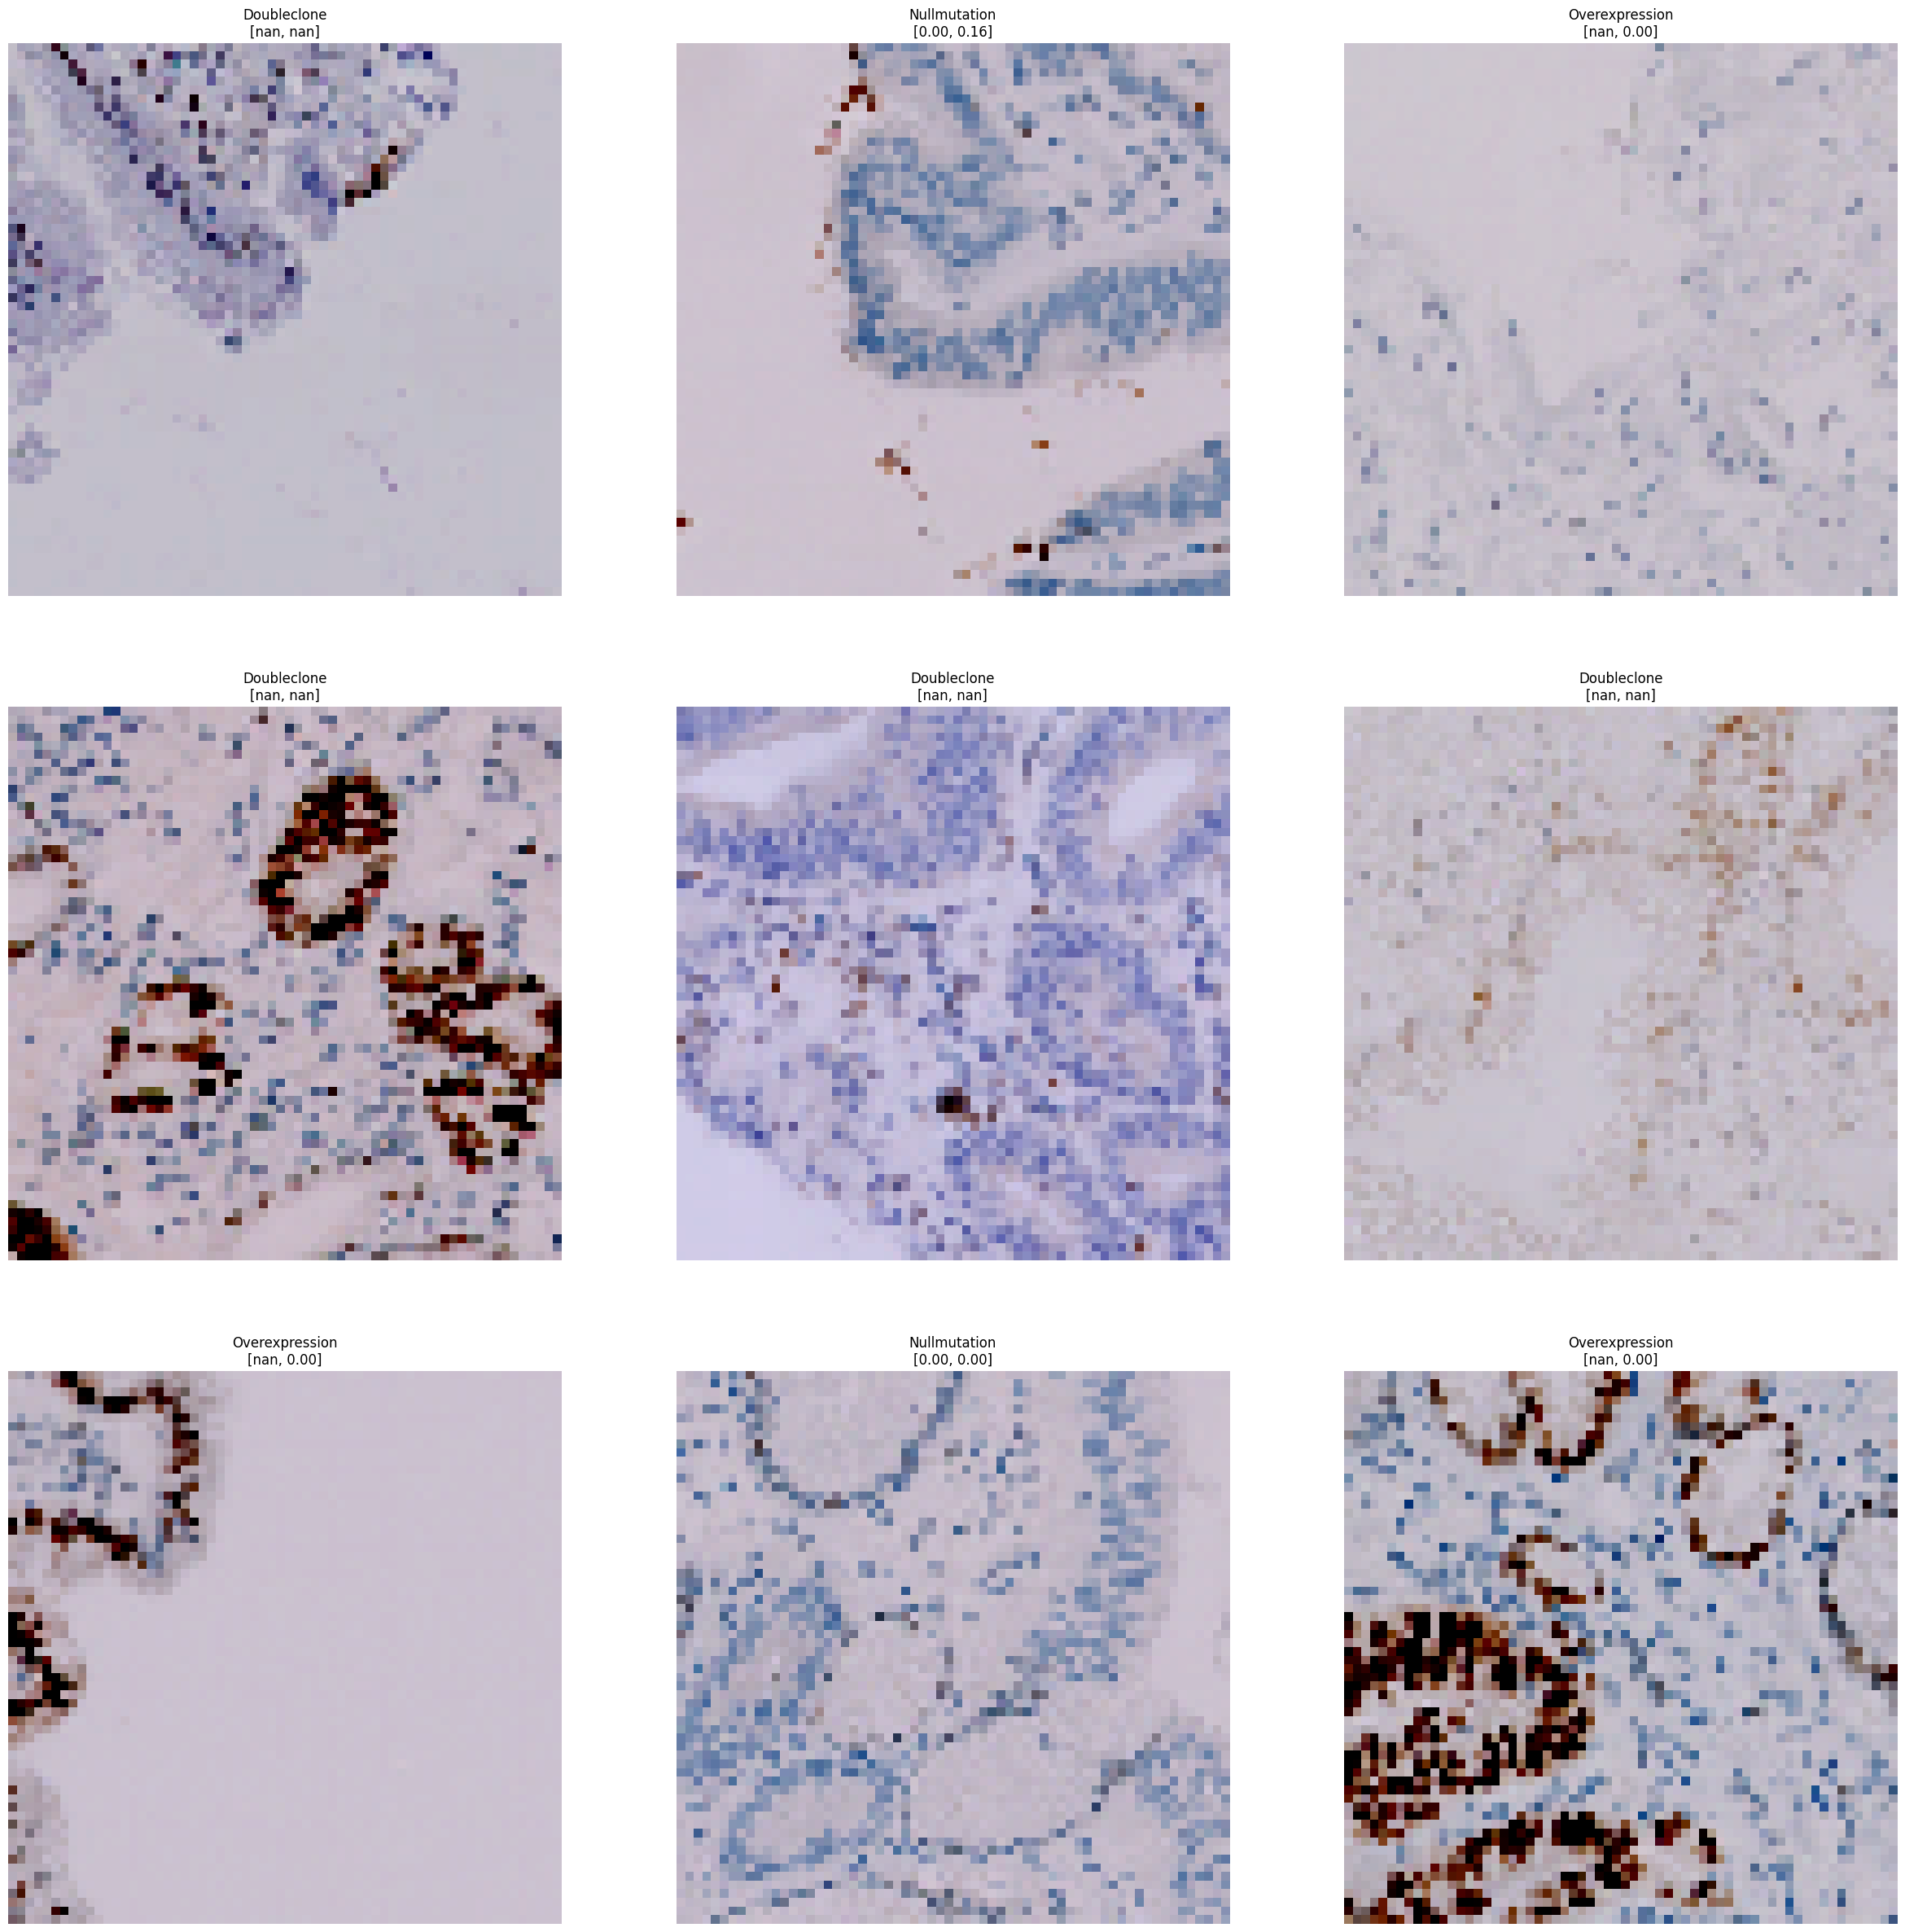

In [3]:
biopsies_dataset.plot_example_grid(figsize=(30,30), n=3)

In [4]:
# Hyper-parameters
batch_size = 1
learning_rate = 1e-5

In [5]:
train_transform = TRANSFORMS["basic_normalize"]

# Load the datasets
train_dataset = BagDataset(root_dir=DATA_DIR, class_names=["Wildtype", "Overexpression", "Nullmutation", "Doubleclone"],
    size=64, labels_filename="train", transform=train_transform)

Class distribution:  {'Wildtype': 1125, 'Overexpression': 251, 'Nullmutation': 96, 'Doubleclone': 0}
Loaded bags from file


In [7]:
test_transform = TRANSFORMS["normalize"]
test_dataset = BagDataset(root_dir=DATA_DIR, class_names=["Wildtype", "Overexpression", "Nullmutation", "Doubleclone"],
    size=64, labels_filename="test", transform=test_transform)

# Data loader using sampler for class balance
weights_factor = None
weights_factor = np.array([1.0, 1.0, 1.0, 0.0])
train_loader = get_balanced_dataloader(train_dataset, batch_size=batch_size, weights_factor=weights_factor)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Class distribution:  {'Wildtype': 15, 'Overexpression': 15, 'Nullmutation': 15, 'Doubleclone': 15}
Loaded bags from file


205 1381
2 277


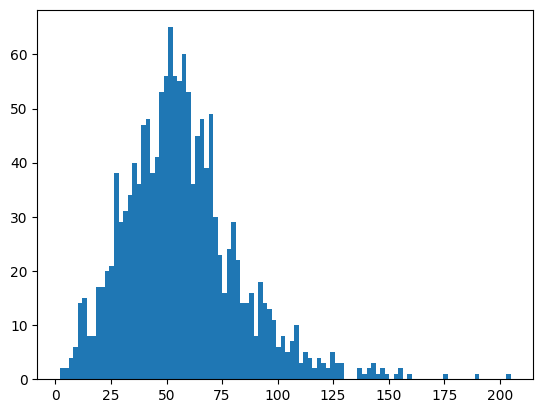

In [8]:
print(np.max(train_dataset.bag_sizes), np.argmax(train_dataset.bag_sizes))
print(np.min(train_dataset.bag_sizes), np.argmin(train_dataset.bag_sizes))

# Plot histogram of bag sizes
plt.hist(train_dataset.bag_sizes, bins=100)
plt.show()

In [9]:
"""
Different architectures for the MIL model:
MILResNetMultiClass
ResNet -> patch latents -> avg -> fc -> softmax
                        -> fc -> patch preds (
    I guess this isn't actually done in MIL)
MILResNetMultiClass
ResNet -> patch softmax -> max
MILResNetDoubleBinary
ResNet -> patch latents -> avg -> fc -> double binary
                        -> fc -> patch preds
ResNet -> patch latents -> fc -> patch preds -> top-k avg (
    pointless because the fc layer can already be learned in the ResNet)
MILResNetPredAggr (This is already basic MIL)
ResNet -> patch preds   -> top-k avg
"""


class MILResNetMultiClass(nn.Module):
    def __init__(self, pretrained=True, num_classes=4):
        super(MILResNetMultiClass, self).__init__()
        self.resnet = models.resnet18(pretrained=pretrained)
        num_ftrs = self.resnet.fc.in_features
        # We want to aggregate the features of the last layer
        self.resnet.fc = nn.Identity()
        self.fc = nn.Linear(num_ftrs, num_classes)
        self.softmax = nn.Softmax(dim=1)

        self.patch_fc = nn.Linear(num_ftrs, 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, return_patch_preds=False):
        B = x.shape[0]
        assert B == 1, "Batch size must be 1, more bags not supported yet"

        # x is a bag of images
        x = x.view(-1, x.shape[2], x.shape[3], x.shape[4]) # (B*N, C, H, W)
        patch_latents = self.resnet(x) # (B*N, num_ftrs)
        patch_preds = self.fc(patch_latents) # (B*N, num_classes)

        m = patch_preds.view(1, -1).argmax(dim=1) # This is the highest scoring probability
        max_patch_idx = m // x.shape[0] # This is the index of the highest scoring patch
        pred = patch_preds[max_patch_idx] # shape (1, num_classes)

        # Aggregate patch latents
        # x = torch.mean(x, dim=0, keepdim=True) # (1, num_ftrs)
        # x = self.fc(x) # (1, num_classes)
        # x = self.softmax(x)

        if return_patch_preds:
            # patch_preds = self.patch_fc(patch_latents) # (B*N, 2)
            # patch_preds = self.sigmoid(patch_preds)
            return pred, patch_preds
        return pred

model_mc = MILResNetMultiClass(pretrained=True, num_classes=4).to(device)

c:\Users\321lu\.conda\envs\dl2023\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\321lu\.conda\envs\dl2023\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
num_epochs = 10

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_mc.parameters(), lr=learning_rate)

batch_size = 32

# Train the model
total_step = len(train_loader)
start_time = time.time()
for epoch in range(num_epochs):
    model_mc.train()

    label_list = []
    pred_list = []
    loss = 0
    running_loss = 0.0
    for i, (bags, labels, patch_labels) in enumerate(train_loader):
        # B is 1 for now
        images = bags.to(device) # (B, N, C, H, W)
        labels = labels.to(device) # (B)
        patch_labels = patch_labels.to(device) # (B, N, 2)

        # Forward pass
        outputs, patch_preds = model_mc(images, True) # (1, num_classes) and (B*N, 2)
        # Criterion can take (N, C) and (N) as input
        loss += criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # TODO: Implement loss for patch predictions

        label_list.append(labels.item())
        pred_list.append(torch.argmax(outputs).item())
        running_loss += loss.item()
        if (i+1) % batch_size == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, running_loss / batch_size))
            label_distribution = [label_list.count(i) for i in range(4)]
            pred_distribution = [pred_list.count(i) for i in range(4)]
            accuracy = sum([1 for i in range(len(label_list)) if label_list[i] == pred_list[i]]) / len(label_list)
            print(f"Label distribution: {label_distribution}")
            print(f"Pred distribution: {pred_distribution}")
            print(f"Accuracy: {accuracy}")
            label_list = []
            pred_list = []
            running_loss = 0.0
        loss = 0

    # # Backward and optimize
    # optimizer.zero_grad()
    # loss.backward()
    # optimizer.step()

    # Test accuracy per class
    accuracy_per_class, _ = get_accuracy_per_class(model_mc, test_loader, device)
    print(f"Accuracy per class: {accuracy_per_class}")
    print(f"Average accuracy: {np.mean(accuracy_per_class)}")
    print(f"Time elapsed: {time.time()-start_time} seconds")

Epoch [1/10], Step [32/1472], Loss: 1.6504
Label distribution: [6, 15, 11, 0]
Pred distribution: [2, 11, 7, 12]
Accuracy: 0.21875
Epoch [1/10], Step [64/1472], Loss: 1.8293
Label distribution: [12, 11, 9, 0]
Pred distribution: [2, 11, 9, 10]
Accuracy: 0.15625
Epoch [1/10], Step [96/1472], Loss: 1.7526
Label distribution: [6, 14, 12, 0]
Pred distribution: [2, 7, 12, 11]
Accuracy: 0.15625
Epoch [1/10], Step [128/1472], Loss: 1.4092
Label distribution: [14, 8, 10, 0]
Pred distribution: [4, 11, 11, 6]
Accuracy: 0.25
Epoch [1/10], Step [160/1472], Loss: 1.6954
Label distribution: [12, 9, 11, 0]
Pred distribution: [3, 10, 12, 7]
Accuracy: 0.21875
Epoch [1/10], Step [192/1472], Loss: 1.3479
Label distribution: [6, 14, 12, 0]
Pred distribution: [6, 9, 10, 7]
Accuracy: 0.3125
Epoch [1/10], Step [224/1472], Loss: 1.5922
Label distribution: [5, 17, 10, 0]
Pred distribution: [6, 14, 6, 6]
Accuracy: 0.3125
Epoch [1/10], Step [256/1472], Loss: 1.6181
Label distribution: [12, 10, 10, 0]
Pred distribu

RuntimeError: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
# Evaluate the model
model_mc.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)

with torch.no_grad():
    accuracy_per_class, confusion_matrix = get_accuracy_per_class(model_mc, test_loader, device)
    print(f"Accuracy per class: {accuracy_per_class}")
    print(f"Average accuracy: {np.mean(accuracy_per_class)}")
    print(f"Confusion matrix: {confusion_matrix}")

In [ ]:
torch.save(model_mc.state_dict(), "models/model_mc.ckpt")

In [ ]:
def convert_status_to_presence(labels):
    """
    Convert labels, which are 0: wildtype, 1: overexpression, 2: nullmutation, 3: doubleclone
    to an array of size 2, where the first element is 1 if overexpression is present, and the second element is 1 if nullmutation is present.
    Wildtype is [0, 0], overexpression is [1, 0], nullmutation is [0, 1], doubleclone is [1, 1].
    """
    return torch.stack([(labels == 1) | (labels == 3), (labels == 2) | (labels == 3)], dim=1).float()

def convert_presence_to_status(presence):
    """
    Convert presence, which is an array of size 2, where the first element is 1 if overexpression is present, and the second element is 1 if nullmutation is present,
    to pred labels, where 0: wildtype, 1: overexpression, 2: nullmutation, 3: doubleclone.
    """
    labels = torch.zeros(presence.size(0), dtype=torch.float, device=presence.device) # Labels per sample

    # Get the presence prediction
    presence = presence > 0.5

    # Calculate the status
    labels += presence[:, 0] * 1
    labels += presence[:, 1] * 2
    return labels

In [ ]:
class MILResNet2Head(nn.Module):
    def __init__(self, pretrained=True, num_classes=4):
        super(MILResNet2Head, self).__init__()
        self.resnet = models.resnet18(pretrained=pretrained)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()
        # Two heads, one for overexpression and one for nullmutation
        self.head1 = nn.Linear(num_ftrs, 1)
        self.head2 = nn.Linear(num_ftrs, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.view(-1, x.shape[2], x.shape[3], x.shape[4]) # (B*N, C, H, W)
        x = self.resnet(x)
        x1 = self.head1(x)
        x2 = self.head2(x)
        # Take maximum over the bag so we have (B, 1) for each head
        x1 = torch.max(x1, dim=0, keepdim=True)[0]
        x2 = torch.max(x2, dim=0, keepdim=True)[0]
        x = torch.cat((x1, x2), dim=1) # (B, 2)
        x = self.sigmoid(x)
        return x 

model_2head = MILResNet2Head(pretrained=True, num_classes=4).to(device)

In [ ]:
num_epochs = 10

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model_2head.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
start_time = time.time()
for epoch in range(num_epochs):
    model_2head.train()

    running_loss = 0.0
    label_distribution = [0, 0, 0, 0]
    pred_distribution = [0, 0, 0, 0]
    for i, (bags, labels) in enumerate(train_loader):
        # B is 1 for now
        images = bags.to(device) # (B, N, C, H, W)
        labels = labels.to(device) # (B)

        # Forward pass
        outputs = model_2head(images) # (1, 2)
        labels = convert_status_to_presence(labels)
        loss = criterion(outputs, labels)

        # More weight on abnormalities
        loss = loss * (1 + torch.sum(labels))

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        label_distribution[int(convert_presence_to_status(labels).item())] += 1
        pred_distribution[int(convert_presence_to_status(outputs).item())] += 1
        if (i+1) % 100 == 0:
            running_loss /= 100
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, running_loss))
            print(f"Label distribution: {label_distribution}")
            print(f"Pred distribution: {pred_distribution}")
            running_loss = 0.0
            label_distribution = [0, 0, 0, 0]
            pred_distribution = [0, 0, 0, 0]

    # Test the model
    model_2head.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)

    # Test accuracy per class
    with torch.no_grad():
        accuracy_per_class, _ = get_accuracy_per_class(model_2head, test_loader, device, convert_presence_to_status)
        print(f"Accuracy per class: {accuracy_per_class}")
        print(f"Average accuracy: {np.mean(accuracy_per_class)}")
        print(f"Time elapsed: {time.time()-start_time} seconds")

    # Save the model checkpoint
    torch.save(model_2head.state_dict(), 'models/MILresnet2Head.ckpt')